In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

### scipy.optimize优化库测试

#### 1.生成一个存在两个极值点的函数

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14324\2796242067.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


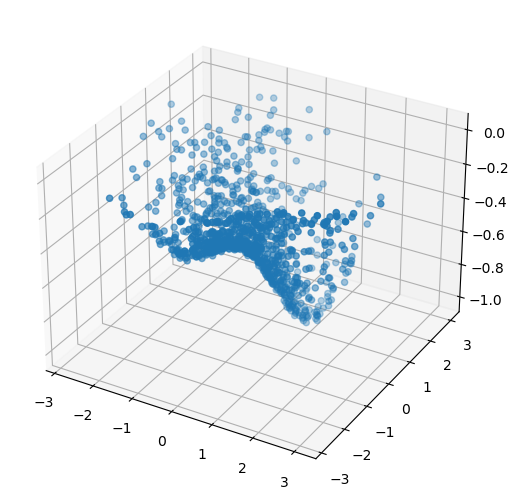

In [2]:
# 二维正态分布生成函数
def gaussian2d(x, y, x_mean, y_mean, x_std, y_std):
    return np.exp(-((x - x_mean) ** 2 / (2 * x_std ** 2) + (y - y_mean) ** 2 / (2 * y_std ** 2)))
# 随机生成二维点
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)
# 混合高斯分布
z = -gaussian2d(x, y, 1, 1, 1, 1) - 0.5*gaussian2d(x, y, -1, -1, 1, 1) + 0.01 * np.random.normal(0, 1, x.shape[0])
points = np.stack([x, y, z], axis=1)
# 三维可视化
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
plt.show()

#### 2.使用minimize函数求解平滑函数极值
jacob和hess都使用数值方法计算

In [3]:
# 优化函数对象
def mix_gaussian(params):
    return -gaussian2d(params[0], params[1], 1, 1, 1, 1) - 0.5*gaussian2d(params[0], params[1], -1, -1, 1, 1)

1. 初值不合适（落入局部极值）

In [4]:
# 对不带噪声的函数进行优化
res = minimize(mix_gaussian, [-0.5, -0.5])
res

      fun: -0.5220881619820461
 hess_inv: array([[2.1021372, 1.1021372],
       [1.1021372, 2.1021372]])
      jac: array([7.4505806e-09, 7.4505806e-09])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([-0.89397408, -0.89397408])

2. 初值合适（落入全局最小值）

In [5]:
# 对不带噪声的函数进行优化
res = minimize(mix_gaussian, [0.5, 0.5])
res

      fun: -1.0095167969634018
 hess_inv: array([[1.03743162, 0.03743162],
       [0.03743162, 1.03743162]])
      jac: array([2.98023224e-08, 2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([0.98038365, 0.98038365])

#### 3.使用minimize函数求解非平滑函数极值
jacob和hess都使用数值方法计算

In [6]:
def mix_gaussian_noise(params):
    return -gaussian2d(params[0], params[1], 1, 1, 1, 1) - 0.5*gaussian2d(params[0], params[1], -1, -1, 1, 1) + 0.01 * np.random.normal(0, 1, 1)

1. 直接对带噪声的函数进行优化（失败，因为数值求解出的梯度过大）

In [7]:
# 对不带噪声的函数进行优化
res = minimize(mix_gaussian_noise, [-0.5, -0.5])
res

      fun: -0.5117224531131495
 hess_inv: array([[ 1.09812631e-17, -7.44161449e-18],
       [-7.44161449e-18,  5.06980529e-18]])
      jac: array([741150.96743415,  85688.57261636])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 116
      nit: 5
     njev: 29
   status: 2
  success: False
        x: array([-0.49997857, -0.49999779])

2. 手动给定jacob和hess计算方法（使用更加大$\Delta x$求jacob和hess，相当于做了一个平滑），更好的是能给出解析解。
[黑塞矩阵用如下方法求解：](https://blog.csdn.net/u012958850/article/details/130324368)
$$
\begin{array}{c}
\frac{\partial^{2} f\left(\boldsymbol{x}_{1}\right)}{\partial x_{i} \partial x_{j}} \approx\left[f\left(\boldsymbol{x}_{1}+\left(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}\right) \frac{\Delta x}{2}\right)+f\left(\boldsymbol{x}_{1}-\left(\boldsymbol{e}_{i}+\boldsymbol{e}_{j}\right) \frac{\Delta x}{2}\right)\right. \\
\left.-f\left(\boldsymbol{x}_{1}+\left(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}\right) \frac{\Delta x}{2}\right)-f\left(\boldsymbol{x}_{1}-\left(\boldsymbol{e}_{i}-\boldsymbol{e}_{j}\right) \frac{\Delta x}{2}\right)\right] / \Delta x^{2}, 1 \leq i, j \leq n
\end{array}
$$

In [8]:
def grad(x1):
    f = mix_gaussian_noise
    dx = 0.3
    n = x1.size
    e = np.eye(n)
    g0 = np.zeros(n)
    for i in range(n):
        g0[i] = (f(x1+e[i]*dx/2)-f(x1-e[i]*dx/2))/dx
    return g0
def hess(x1):
    f = mix_gaussian_noise
    dx = 0.3
    n = x1.size
    e = np.eye(n)
    H0 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            H0[i, j] = (f(x1+(e[i]+e[j])*dx/2)+f(x1-(e[i]+e[j])*dx/2) -
                        f(x1+(e[i]-e[j])*dx/2)-f(x1-(e[i]-e[j])*dx/2))/dx**2
    return H0

In [9]:
# 使用自定义的梯度和海森矩阵
res = minimize(mix_gaussian_noise, [0.2, 0.2], jac=grad, hess=hess, method='newton-cg', options={'disp': True, 'gtol': 0.1})
res

         Current function value: -0.660979
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 1


C:\Users\lenovo\AppData\Local\Temp\ipykernel_14324\2994627789.py:2: OptimizeWarning: Unknown solver options: gtol
  res = minimize(mix_gaussian_noise, [0.2, 0.2], jac=grad, hess=hess, method='newton-cg', options={'disp': True, 'gtol': 0.1})


     fun: -0.6609788871533635
     jac: None
 message: "Warning: CG iterations didn't converge. The Hessian is not positive definite."
    nfev: 1
    nhev: 1
     nit: 0
    njev: 1
  status: 3
 success: False
       x: array([0.2, 0.2])

In [10]:
# 直接修改原函数内部在数值计算时的步长
res = minimize(mix_gaussian_noise, [0.2, 0.2], method='BFGS', options={'disp': True, 'gtol': 0.1, 'eps': 0.1})
res

         Current function value: -1.010458
         Iterations: 3
         Function evaluations: 47
         Gradient evaluations: 13


      fun: -1.010458345593621
 hess_inv: array([[ 3.67338976, -0.24578038],
       [-0.24578038,  0.34324689]])
      jac: array([-0.04686319,  0.19286308])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 47
      nit: 3
     njev: 13
   status: 2
  success: False
        x: array([1.00899167, 1.09851306])

虽然总是返回False，但是实际上基本到了最优解，只是由于数值误差导致的无法收敛。